In [1]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from domid.arg_parser import mk_parser_main
os.chdir('../')
print("Current working directory:", os.getcwd())

Current working directory: /home/didsr/Documents/SDCN_December/DomId


# Some Helper functions that are going to be useful for the analysis of the experimental results

*  `get_most_recent_directory(directory)` takes a directory path as input, retrieves a list of directories within it, sorts them by their creation time in descending order, and returns the path of the most recently created directory. That is how we will obtain the repo with the results for the latest experiment.
* `load_files ` reads a CSV file named "clustering_results.csv" located at the specified path of the experimnet. It then extracts specific columns from the results DataFrame that are used to analyze results.
* `something_per_domain` takes two arrays as input: domain, representing predicted domain labels, and another_label, representing some other label corresponding to each predicted domain label. It calculates the counts of occurrences of combination of predicted domain and another labels (e.g how many red digits in domain 0).
*  `plot_something_per_domain_proportion` generates a bar graph illustrating the proportion of counts for each unique label within each predicted domain.

In [3]:

def get_most_recent_directory(directory):
    try:
        directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
        directories.sort(key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)
        return os.path.join(directory, directories[0])
    except Exception as e:
        print("Error:", e)
        return None



In [4]:

def load_files(path):
    df = pd.read_csv(path+'clustering_results.csv')
    
    domain = df['predictions'].values
    
    vec_d = df['vec_d_labels'].values
    vec_y = df['vec_y_labels'].values
    img_locs = df['image_id_labels'].values

    Z = np.load(path + "Z_space.npy")
    model_name = path.split('_')[-1]

    #args = np.loadtxt(path + "arguments.txt", dtype=str, usecols=0)  # , delimiter = '\n')
    #img_locs = np.loadtxt(path + "img_id.txt", dtype=str)
    
    return domain, vec_d, vec_y, img_locs, model_name

In [5]:
def something_per_domain(domain, another_label):
    """
    domain - predicted domain labels 
    another_label - some other label that corresponds to each of the predicted domain (
    assumed that both domain and something have the same img_loc reference order 
    """
    u_something = np.unique(another_label)
    u_domain = np.unique(domain)
    print('unique predicted domain', u_domain)
    print('unique true label', u_something)
    
    array_counters=[]
    for i in u_domain:
        for j in u_something:
            counter = 0
            for idx in range(0, len(domain)):
                if domain[idx]==i and another_label[idx]==j:
                    counter+=1
            
            array_counters.append(counter)
    return array_counters
                    
        
    

In [6]:
def plot_something_per_domain_proportion(domain, another_label, counts, fs, legend = False, thres = None, title = None, digit_plot = True):
    """
    domain - predicted domain labels
    another_label - another label aassociated with each predicted domain (should be same shape as domain)
    counts - countes of each another label in each of the predicted domain (see something_per_domain function)
    fs - font size
    colors - colors of each segment on the bargraph
    legend - legend of unique another lables
    thres - if thresholding of another label is required then should be shpecifies (also see apply_threshold function)
    
    """
    u_domains = np.unique(domain)
    N = len(u_domains)
    
    u_another_label = np.unique(another_label)
    print('unique labels', u_another_label)
    print(u_domains)
    counts = np.array(counts)
    narray = np.array_split(counts, N)

    if thres:
        u_another_label_dic = apply_threshold(u_another_label, narray, thres, N)
        #print(u_another_label_dic.values())
        u_another_label = list(u_another_label_dic.keys())
        narray = list(u_another_label_dic.values())
        narray = np.transpose(narray)

   # print(narray)
    #print(len(u_domains), len(u_another_label))
    # c = ['blue', 'teal', 'pink', 'orange', 'green', 'red', 'plum', 'grey', 'purple', 'yellow']
    # c = ['lightblue', 'steelblue', 'royalblue', 'mediumpurple', 'darkmagenta','orchid', 'lightpink', 'lightcoral', 'maroon', 'sandybrown']
    
    if digit_plot:
        c =  ['darkseagreen', 'forestgreen', 'aquamarine', 'lightseagreen', 'teal', 'steelblue','lightblue', 'royalblue','navy', 'lightslategrey' ]

    else:
        c = ['mediumpurple', 'darkmagenta','orchid', 'lightpink', 'lightcoral', 'maroon', 'sandybrown', 'peachpuff', 'goldenrod', 'gold']
  
        
    plt.figure(figsize = (5, 5))
    for i in range(0, len(u_domains)):
        for jj in range(0,len(u_another_label)):
            
            if jj>0:
                bottom = np.sum(narray[i][:jj])/np.sum(narray[i])
            else:
                bottom = 0
            ##print(i, narray[i][jj])
            #print(c[jj])
            plt.bar(i, narray[i][jj]/np.sum(narray[i]), bottom = bottom, color = c[jj])
    x = np.linspace(0, N-1, N)
    x_ticks = [str(item)[0] for item in u_domains]
    #plt.ylabel("Proportion", fontsize=fs)
    plt.xticks(x, x_ticks, fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel("Domain", fontsize=fs)
    plt.title(title, fontsize = fs, weight = 'bold')
    plt.tick_params(left = False, labelleft = False)
    if legend:
        plt.legend(legend, bbox_to_anchor=(0.5, 10))
    else:
        plt.legend(u_another_label, bbox_to_anchor=(1, 1.1), fancybox=True, shadow=True, fontsize = fs)
    plt.show()

# VaDE with Colored MNIST 

In [6]:
# parser = mk_parser_main()
# args = parser.parse_args(
#     ["--task",
#         "mnistcolor10",
#          "--te_d", "0",
#         "--tr_d", "0","1","2","3", "4", "5", "6", "7", "8", "9", 
#         "--zd_dim", "20",
#         "--d_dim","10",
#         "--dpath", "zout",
#         "--model", "vade",
#         "--apath", "domid/algos/builder_vade.py",
#         "--bs", "2",
#         "--split", "0.8",
#         "--L", "5",
#         "--debug", "--nocu",
#         "--model_method", "cnn",
#         "--prior", "Gaus",
#         "--pre_tr","9",
#         "--epos", "20",
#          "--lr", "0.0005",
#         "--trainer","cluster",
#         "--feat_extract","vae"
#     ]
# )

In [7]:
# from domid.trainers.zoo_trainer import TrainerChainNodeGetter
# from domid.tasks.task_mnist_color import NodeTaskMNISTColor10

# from domid.models.model_vade import mk_vade
# from domid.models.model_dec import mk_dec

# from domid.algos.observers.b_obvisitor_clustering_only import ObVisitorClusteringOnly
# from domainlab.algos.observers.c_obvisitor_cleanup import ObVisitorCleanUp
# from domainlab.algos.msels.c_msel_oracle import MSelOracleVisitor
# from domainlab.algos.msels.c_msel_val import MSelValPerf
# from domid.compos.exp.exp_main import Exp


In [8]:
from domid.mk_exp import mk_exp

# task, model, trainer: str,train_domain:str, test_domain:str, batchsize: int, nocu=True, prior = 'Bern',
#             random_batching=False,
#             model_method='cnn',
#             feat_extract='vae', pre_tr =25):
#     """

In [9]:
exp = mk_exp(task='mnistcolor10', model='vade', 
             trainer='cluster',
             train_domain = '0 1 2 3 4 5 6 7 8 9', 
             test_domain='0', 
             batchsize = 2, pre_tr=2, epos=20 )


The sets of training and test domains overlap -- be aware of data leakage or training to the test!


False
Namespace(config_file=None, lr=0.0001, gamma_reg=0.1, es=1, seed=0, nocu=True, device=None, gen=False, keep_model=False, epos=20, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='cluster', out='zoutput', dpath='zdpath', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='vade', acon=None, task='mnistcolor10', bs=2, split=0, te_d=['0'], tr_d=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], san_check=False, san_num=8, loglevel='DEBUG', zd_dim=64, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=1, 

/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets


/home/didsr/.cache/pypoetry/virtualenvs/domid-_-KOKVIz-py3.10/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0

using device: cpu

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


ConvolutionalEncoder(
  (encod): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=2048, out_features=64, bias=True)
  (log_sigma2_layer): Linear(in_features=2048, out_features=64, bias=True)
)
ConvolutionalDecoder(
  (linear): Linear(in_features=64, out_features=2048, bias=True)
  (sigmoid_layer): Sigmoid()
  (unflat): UnFlatten()
  (decod): S




!!!: not committed yet
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'1542966'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: mnistcolor10_te_rgb_31_119_180_vade_b1542966_not_commited_2024md_03md_07_16_40_52_seed_0


############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________


In [10]:
exp.execute()


 Experiment start at : 2024-03-07 16:40:52.328724
before training, model accuracy: (0.12333333333333334, array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [510, 610, 570, 670, 540, 680, 570, 530, 740, 580],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]), 0.1, array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
  

pi:
[0.10025825 0.09981473 0.09947747 0.10013112 0.10030636 0.09988391
 0.09984208 0.10009952 0.09991983 0.10026674]
epoch: 6
pooled train clustering acc (vec_d correlation):  0.9891666666666666
[[597   0   1   0   0  14   0   1   0   2]
 [  0 590   0   0   0   5   5   0   0   0]
 [  1   0 596   0   0   0   0   0   0   1]
 [  0   0   0 596   0   0   0   0   6   0]
 [  0   0   3   0 600   0   0   0   0   0]
 [  2   5   0   0   0 580   9   0   0   0]
 [  0   5   0   1   0   1 586   0   0   0]
 [  0   0   0   0   0   0   0 599   0   0]
 [  0   0   0   3   0   0   0   0 594   0]
 [  0   0   0   0   0   0   0   0   0 597]]
clustering validation acc:  0.9918333333333333
[[590   0   1   0   0   3   0   0   0   0]
 [  0 588   0   0   0   3   4   0   0   0]
 [  1   0 598   0   2   0   0   0   0   0]
 [  0   0   0 596   0   0   0   0   4   0]
 [  0   0   1   0 598   0   0   1   0   0]
 [  8   4   0   0   0 593   3   0   0   0]
 [  0   8   0   1   0   1 593   0   0   0]
 [  1   0   0   0   0   0 

epoch: 11
pooled train clustering acc (vec_d correlation):  0.9836666666666667
[[587   0   0   0   0   0   1   4   0   0]
 [  0 595   0   1   0   1   0   0   7   0]
 [  0   0 593   0   1   0   0   0   0   8]
 [  0   0   0 598   0   1   0   0   0   0]
 [  0   0   1   0 599   7   0   0   0   0]
 [  0   0   3   1   0 576   0   7   0   3]
 [  3   2   0   0   0   0 590   3   2   0]
 [ 10   0   0   0   0   6   6 585   1   0]
 [  0   3   0   0   0   0   3   1 590   0]
 [  0   0   3   0   0   9   0   0   0 589]]
clustering validation acc:  0.9828333333333333
[[592   0   0   0   0   0   2   8   0   0]
 [  0 595   0   4   0   1   2   0  12   0]
 [  0   0 597   0   3   1   0   0   0  10]
 [  0   0   0 596   0   1   0   0   0   0]
 [  0   0   1   0 595   3   0   0   0   0]
 [  0   0   0   0   2 584   0  12   0   1]
 [  4   0   0   0   0   2 591   4   3   0]
 [  4   0   0   0   0   6   1 574   1   0]
 [  0   5   0   0   0   0   4   0 584   0]
 [  0   0   2   0   0   2   0   2   0 589]]
pooled train

pi:
[0.09897503 0.10065017 0.10041586 0.09855174 0.09881364 0.09892507
 0.10124988 0.09997916 0.10027745 0.10216201]
epoch: 16
pooled train clustering acc (vec_d correlation):  0.9706666666666667
[[582   0   0   0   0   0   9   0   6   2]
 [  0 567   0   5   3   0   0   2   0  10]
 [  0   0 590   3   0   0   0  12   0   0]
 [  0  10   1 580   3   0   0   5   0   0]
 [  0   7   0   6 594   0   0   0   0   1]
 [  0   0   3   0   0 593   2   0   0   4]
 [  8   0   0   0   0   0 578   0   0   8]
 [  0   2   5   6   0   0   0 581   0   0]
 [  4   0   0   0   0   0   0   0 588   4]
 [  6  14   1   0   0   7  11   0   6 571]]
clustering validation acc:  0.9726666666666667
[[587   0   0   0   0   0  10   0   6   1]
 [  0 573   0   5   7   0   2   1   0   9]
 [  0   0 583   1   0   2   0   6   0   0]
 [  0  10   8 582   6   0   0   7   0   0]
 [  0   5   0   6 587   0   0   0   0   1]
 [  0   0   0   0   0 588   1   0   0   3]
 [  8   0   0   0   0   1 580   0   0   3]
 [  0   1   8   6   0   1

/home/didsr/Documents/SDCN_December/DomId/domid/utils/storing.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(row, ignore_index=True)
/home/didsr/Documents/SDCN_December/DomId/domid/algos/observers/c_obvisitor_clustering.py:107: UserWarning: failed to delete model
  warnings.warn("failed to delete model")


In [11]:


directory = "./notebooks"
vade_results_path = get_most_recent_directory(directory)
print('Results from the following folder are going to be analyzed: ', vade_results_path)


domain, vec_d, vec_y, img_locs, model_name = load_files(vade_results_path+'/')
color = vec_d
digit = vec_y
model_name = 'VaDE'

Results from the following folder are going to be analyzed:  ./notebooks/2024-03-07 16:40:52.291450_mnistcolor10_vade


In [12]:
digits_per_domain = something_per_domain(domain, digit)

unique predicted domain [ 1  2  3  4  5  6  7  8  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]


In [13]:
colors_per_domain = something_per_domain(domain, color)

unique predicted domain [ 1  2  3  4  5  6  7  8  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]


unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


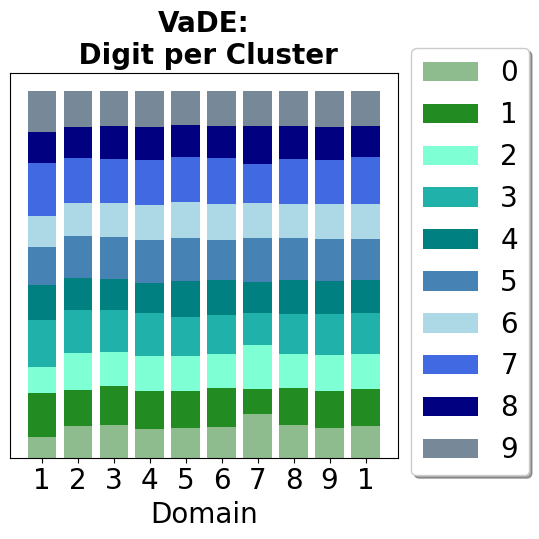

In [14]:
plot_something_per_domain_proportion(domain, digit, digits_per_domain, fs =20,title = model_name+':\n Digit per Cluster')

unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


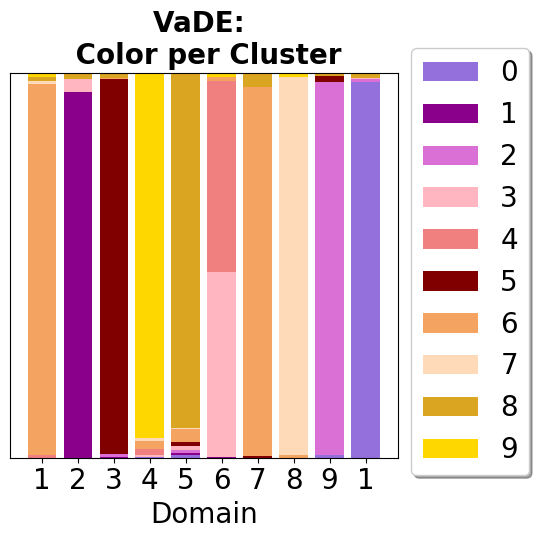

In [15]:
plot_something_per_domain_proportion(domain, color, colors_per_domain, fs =20, title = model_name+': \n Color per Cluster', digit_plot = False ) 

# DEC with Colored MNIST 

In [1]:
# parser = mk_parser_main()
# args = parser.parse_args(
#     ["--task",
#         "mnistcolor10",
#          "--te_d", "0",
#         "--tr_d", "0","1","2","3", "4", "5", "6", "7", "8", "9", 
#         "--zd_dim", "20",
#         "--d_dim","10",
#         "--dpath", "zout",
#         "--model", "dec",
#         "--apath", "domid/algos/builder_dec.py",
#         "--bs", "2",
#         "--split", "0.8",
#         "--L", "5",
#         "--debug", "--nocu",
#         "--model_method", "cnn",
#         "--prior", "Gaus",
#         "--pre_tr","9",
#         "--epos", "20",
#          "--lr", "0.0005",
#         "--trainer","cluster",
#         "--feat_extract","vae"
#     ]
# )

In [7]:
from domid.mk_exp import mk_exp
exp = mk_exp(task='mnistcolor10', model='dec', 
             trainer='cluster',
             train_domain = '0 1 2 3 4 5 6 7 8 9', 
             test_domain='0', 
             batchsize = 2, pre_tr=2, epos=20 )
exp.execute()

The sets of training and test domains overlap -- be aware of data leakage or training to the test!


False
Namespace(config_file=None, lr=0.0001, gamma_reg=0.1, es=1, seed=0, nocu=True, device=None, gen=False, keep_model=False, epos=20, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='cluster', out='zoutput', dpath='zdpath', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='dec', acon=None, task='mnistcolor10', bs=2, split=0, te_d=['0'], tr_d=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], san_check=False, san_num=8, loglevel='DEBUG', zd_dim=64, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=1, n

/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets



using device: cpu

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets





!!!: not committed yet
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'1542966'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: mnistcolor10_te_rgb_31_119_180_dec_b1542966_not_commited_2024md_03md_07_17_18_50_seed_0


############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________

 Experiment start at : 2024-03-07 17:18:50.743014
before training, model accuracy: (0.12333333333333334, array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [510, 610, 570, 670, 540, 680, 570, 530, 740, 580],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]), 0.1, array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 

epoch: 6
pooled train clustering acc (vec_d correlation):  1.0
[[600   0   0   0   0   0   0   0   0   0]
 [  0 600   0   0   0   0   0   0   0   0]
 [  0   0 600   0   0   0   0   0   0   0]
 [  0   0   0 600   0   0   0   0   0   0]
 [  0   0   0   0 600   0   0   0   0   0]
 [  0   0   0   0   0 600   0   0   0   0]
 [  0   0   0   0   0   0 600   0   0   0]
 [  0   0   0   0   0   0   0 600   0   0]
 [  0   0   0   0   0   0   0   0 600   0]
 [  0   0   0   0   0   0   0   0   0 600]]
clustering validation acc:  1.0
[[600   0   0   0   0   0   0   0   0   0]
 [  0 600   0   0   0   0   0   0   0   0]
 [  0   0 600   0   0   0   0   0   0   0]
 [  0   0   0 600   0   0   0   0   0   0]
 [  0   0   0   0 600   0   0   0   0   0]
 [  0   0   0   0   0 600   0   0   0   0]
 [  0   0   0   0   0   0 600   0   0   0]
 [  0   0   0   0   0   0   0 600   0   0]
 [  0   0   0   0   0   0   0   0 600   0]
 [  0   0   0   0   0   0   0   0   0 600]]
pooled train clustering acc (vec_y correlat

epoch: 12
pooled train clustering acc (vec_d correlation):  1.0
[[600   0   0   0   0   0   0   0   0   0]
 [  0 600   0   0   0   0   0   0   0   0]
 [  0   0 600   0   0   0   0   0   0   0]
 [  0   0   0 600   0   0   0   0   0   0]
 [  0   0   0   0 600   0   0   0   0   0]
 [  0   0   0   0   0 600   0   0   0   0]
 [  0   0   0   0   0   0 600   0   0   0]
 [  0   0   0   0   0   0   0 600   0   0]
 [  0   0   0   0   0   0   0   0 600   0]
 [  0   0   0   0   0   0   0   0   0 600]]
clustering validation acc:  1.0
[[600   0   0   0   0   0   0   0   0   0]
 [  0 600   0   0   0   0   0   0   0   0]
 [  0   0 600   0   0   0   0   0   0   0]
 [  0   0   0 600   0   0   0   0   0   0]
 [  0   0   0   0 600   0   0   0   0   0]
 [  0   0   0   0   0 600   0   0   0   0]
 [  0   0   0   0   0   0 600   0   0   0]
 [  0   0   0   0   0   0   0 600   0   0]
 [  0   0   0   0   0   0   0   0 600   0]
 [  0   0   0   0   0   0   0   0   0 600]]
pooled train clustering acc (vec_y correla

epoch: 18
pooled train clustering acc (vec_d correlation):  1.0
[[600   0   0   0   0   0   0   0   0   0]
 [  0 600   0   0   0   0   0   0   0   0]
 [  0   0 600   0   0   0   0   0   0   0]
 [  0   0   0 600   0   0   0   0   0   0]
 [  0   0   0   0 600   0   0   0   0   0]
 [  0   0   0   0   0 600   0   0   0   0]
 [  0   0   0   0   0   0 600   0   0   0]
 [  0   0   0   0   0   0   0 600   0   0]
 [  0   0   0   0   0   0   0   0 600   0]
 [  0   0   0   0   0   0   0   0   0 600]]
clustering validation acc:  1.0
[[600   0   0   0   0   0   0   0   0   0]
 [  0 600   0   0   0   0   0   0   0   0]
 [  0   0 600   0   0   0   0   0   0   0]
 [  0   0   0 600   0   0   0   0   0   0]
 [  0   0   0   0 600   0   0   0   0   0]
 [  0   0   0   0   0 600   0   0   0   0]
 [  0   0   0   0   0   0 600   0   0   0]
 [  0   0   0   0   0   0   0 600   0   0]
 [  0   0   0   0   0   0   0   0 600   0]
 [  0   0   0   0   0   0   0   0   0 600]]
pooled train clustering acc (vec_y correla

/home/didsr/Documents/SDCN_December/DomId/domid/utils/storing.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(row, ignore_index=True)
/home/didsr/Documents/SDCN_December/DomId/domid/algos/observers/c_obvisitor_clustering.py:107: UserWarning: failed to delete model
  warnings.warn("failed to delete model")


In [8]:


directory = "./notebooks"
dec_results_path = get_most_recent_directory(directory)
print('Results from the following folder are going to be analyzed: ', dec_results_path)


domain, vec_d, vec_y, img_locs, model_name = load_files(dec_results_path+'/')
color = vec_d
digit = vec_y
model_name ='DEC'

Results from the following folder are going to be analyzed:  ./notebooks/2024-03-07 17:18:50.708699_mnistcolor10_dec


unique predicted domain [ 1  2  3  4  5  6  7  8  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]
unique predicted domain [ 1  2  3  4  5  6  7  8  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]
unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


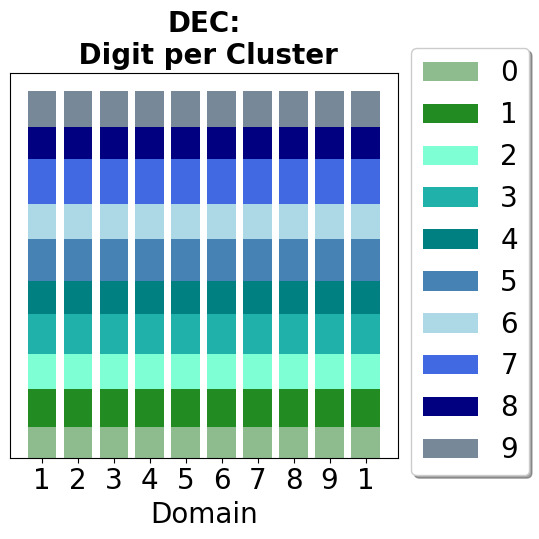

unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


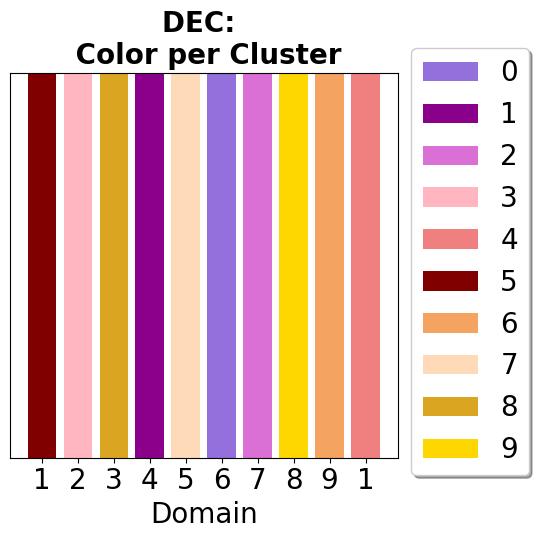

In [9]:
digits_per_domain = something_per_domain(domain, digit)
colors_per_domain = something_per_domain(domain, color)
plot_something_per_domain_proportion(domain, digit, digits_per_domain, fs =20,title = model_name+':\n Digit per Cluster')
plot_something_per_domain_proportion(domain, color, colors_per_domain, fs =20, title = model_name+': \n Color per Cluster', digit_plot = False ) 

# CDVaDE for Colored MNIST 

In [ ]:
# parser = mk_parser_main()
# args = parser.parse_args(
#     ["--task",
#         "mnistcolor10",
#          "--te_d", "0",
#         "--tr_d", "0","1","2","3", "4", "5", "6", "7", "8", "9", 
#         "--zd_dim", "20",
#         "--d_dim","10",
#         "--dpath", "zout",
#         "--model", "vade",
#         "--apath", "domid/algos/builder_vade.py",
#         "--bs", "2",
#         "--split", "0.8",
#         "--L", "5",
#         "--debug", "--nocu",
#         "--model_method", "cnn",
#         "--prior", "Gaus",
#         "--pre_tr","10",
#         "--epos", "25",
#          "--lr", "0.0005",
#         "--trainer","cluster",
#         "--feat_extract","vae",
#          "--inject_var", "color",
#          "--dim_inject", "10"
#     ]
# )

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from domid.arg_parser import mk_parser_main
os.chdir('../')
print("Current working directory:", os.getcwd())

Current working directory: /home/didsr/Documents/SDCN_December/DomId


In [ ]:
from domid.mk_exp import mk_exp
exp = mk_exp(task='mnistcolor10', model='vade', 
             trainer='cluster',
             train_domain = '0 1 2 3 4 5 6 7 8 9', 
             test_domain='0', 
             batchsize = 2, pre_tr=10, epos=25,
            inject_var = 'color', dim_inject = 10)
exp.execute()

The sets of training and test domains overlap -- be aware of data leakage or training to the test!


False
Namespace(config_file=None, lr=0.0001, gamma_reg=0.1, es=1, seed=0, nocu=True, device=None, gen=False, keep_model=False, epos=25, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='cluster', out='zoutput', dpath='zdpath', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='vade', acon=None, task='mnistcolor10', bs=2, split=0, te_d=['0'], tr_d=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], san_check=False, san_num=8, loglevel='DEBUG', zd_dim=10, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=1, 

/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets


/home/didsr/.cache/pypoetry/virtualenvs/domid-_-KOKVIz-py3.10/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0

using device: cpu

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


ConvolutionalEncoder(
  (encod): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=2048, out_features=10, bias=True)
  (log_sigma2_layer): Linear(in_features=2048, out_features=10, bias=True)
)
ConvolutionalDecoder(
  (linear): Linear(in_features=20, out_features=2048, bias=True)
  (sigmoid_layer): Sigmoid()
  (unflat): UnFlatten()
  (decod): S




!!!: not committed yet
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'60922b3'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: mnistcolor10_te_rgb_31_119_180_vade_b60922b3_not_commited_2024md_03md_07_18_13_11_seed_0


############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________

 Experiment start at : 2024-03-07 18:13:11.391201
before training, model accuracy: (0.12333333333333334, array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [510, 610, 570, 670, 540, 680, 570, 530, 740, 580],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]), 0.1, array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 

epoch: 5
pooled train clustering acc (vec_d correlation):  0.555
[[ 61  51   1   0   0 199  41   5  14   4]
 [ 45 448   0   0   0 164   3  29  11   2]
 [ 15   2 311   4  12   1  11   1  61  92]
 [  3   0  49 553 310   0   0  36  32   3]
 [ 20   0  88  21 163   0   2  13  46  11]
 [ 18   9   4   0   1 163  90   1   1   3]
 [ 63   1  15   1   1  52 415   1  29  16]
 [ 43  32   0  12  38   4   1 456  29   0]
 [319  54  45   8  72  10  16  58 308  17]
 [ 13   3  87   1   3   7  21   0  69 452]]
clustering validation acc:  0.5495
[[ 69  55   2   0   0 200  46   4  14   7]
 [ 47 452   0   0   0 158   2  17  13   6]
 [ 11   1 299   7  14   3  13   0  60  94]
 [  2   0  57 549 320   0   0  26  36   3]
 [ 16   0  90  25 170   0   6  12  60   9]
 [ 23   8   1   0   0 169 112   0   5   3]
 [ 80   1  15   0   1  49 384   0  22  19]
 [ 42  38   0  11  30   4   0 479  27   0]
 [296  42  43   8  64  10  17  62 292  25]
 [ 14   3  93   0   1   7  20   0  71 434]]
pooled train clustering acc (vec_y cor

############################################################
Epoch 10: Finished pretraining and starting to use the full model loss.
############################################################
pi:
[0.07567149 0.14718696 0.0746429  0.10335346 0.08876124 0.09438135
 0.10018529 0.08359073 0.13592991 0.09629664]
epoch: 10
pooled train clustering acc (vec_d correlation):  0.532
[[175   0   0 107   0   0   0   0   0   0]
 [  0 600   0   0   0   0   0 593   0   0]
 [167   0   0  30   0  67   0   0   0   0]
 [249   0   0 337   0  77   1   0   0   0]
 [  0   0  11   0 182   0   0   1   0   0]
 [  9   0 226   1  24 372   0   0   0   0]
 [  0   0   0 125   0  83 599   0   0   0]
 [  0   0   0   0   0   0   0   1   0 274]
 [  0   0 363   0 394   0   0   0 600   0]
 [  0   0   0   0   0   1   0   5   0 326]]
clustering validation acc:  0.532
[[177   0   0 105   0   0   0   0   0   0]
 [  0 600 595   0   0   0   0   0   0   0]
 [166   0   0  29   0  75   0   0   0   0]
 [248   0   0 334   0  70   6

pi:
[0.0600805  0.16093288 0.05965784 0.1096008  0.06602009 0.10625137
 0.11824939 0.07021345 0.1681275  0.0808662 ]
epoch: 15
pooled train clustering acc (vec_d correlation):  0.5415
[[200   0   0 137   0   0   0   0   0   0]
 [  0 599   0   0   1   0   0 503   0   0]
 [ 93   0   2  33   0   4   0   0   0   0]
 [271   0   4 303   0   0  24   0   0   0]
 [  0   0   0   0  57   2   0   6   0   0]
 [  3   0 502   2  13 548   5  12   0  11]
 [ 33   0  92 125   0   4 571   0   0   0]
 [  0   0   0   0   0   2   0  23   0 243]
 [  0   0   0   0 529  23   0   0 600   0]
 [  0   1   0   0   0  17   0  56   0 346]]
clustering validation acc:  0.537
[[189   0   0 133   0   0   0   0   0   0]
 [  0 599   0   0   1   0   0 503   0   0]
 [ 95   0   1  29   0   3   0   0   0   0]
 [277   0   4 300   0   0  22   0   0   0]
 [  0   0   0   0  59   4   0   5   0   0]
 [  3   0 496   1  14 545   8  10   0  11]
 [ 36   0  98 137   0   5 570   0   0   0]
 [  0   0   0   0   0   2   0  26   0 256]
 [  0  

pi:
[0.05573173 0.15859874 0.05204928 0.09929772 0.05021355 0.13467532
 0.11174563 0.07795179 0.16945799 0.09027831]
epoch: 20
pooled train clustering acc (vec_d correlation):  0.4796666666666667
[[191   0   0 157   0   0  12   0   1   0]
 [  0 537  14   0   2   0   0 386   0 104]
 [ 93   0   3  64   0   0   5   0   0   0]
 [200   0   2 186   0   2  61   0   0   1]
 [  6   1   3   3  62   0   2   4  12   0]
 [ 14  15 437  11  34 511  34  24   4  62]
 [ 94   0   6 179   1  18 486   0   0   1]
 [  0  22  47   0   0  22   0  69   0 182]
 [  0   0   1   0 501   0   0   0 583   0]
 [  2  25  87   0   0  47   0 117   0 250]]
clustering validation acc:  0.48
[[186   0   0 152   1   0  10   0   0   0]
 [  0 534  20   0   3   0   0 388   0 106]
 [ 94   0   1  59   0   0   5   0   0   0]
 [195   0   1 190   1   2  53   0   0   1]
 [  7   1   3   4  60   1   1   5   6   0]
 [ 15  12 428  12  31 507  40  28   3  60]
 [101   0   7 181   1  19 491   0   1   1]
 [  0  25  50   0   0  20   0  67   0 1

In [ ]:


directory = "./notebooks"
cdvade_results_path = get_most_recent_directory(directory)
print('Results from the following folder are going to be analyzed: \n', cdvade_results_path)


domain, vec_d, vec_y, img_locs, model_name = load_files(cdvade_results_path+'/')
color = vec_d
digit = vec_y
model_name = 'CDVaDE'

digits_per_domain = something_per_domain(domain, digit)
colors_per_domain = something_per_domain(domain, color)
plot_something_per_domain_proportion(domain, digit, digits_per_domain, fs =20,title = model_name+':\n Digit per Cluster')
plot_something_per_domain_proportion(domain, color, colors_per_domain, fs =20, title = model_name+': \n Color per Cluster', digit_plot = False ) 